# Raman spectra analysis

Importing necessary libraries:

In [85]:
import pandas as pd
import numpy as np
import math
import glob
import os
import matplotlib.pyplot as plt
from scipy.signal import argrelmin, argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats import ttest_ind
import seaborn as sns

Your measurements should be copied to the "data" folder.
Output results can be saved in "output" polder.

In [2]:
data_directory = 'data/'
out_directory = 'output/'

Reading and combining all .csv files into one dataframe.

In [62]:
def combine_files(src_directory):
    """ Read in all data files and combine into one combined DataFrame
    """
    all_data = pd.DataFrame()
    nameit =[] 
    for f in glob.glob(os.path.join(data_directory, "*.csv")):
        df = pd.read_csv(f,skiprows=(30),sep=";")[:-2] #first 30 and the last two rows with the metadata are removed
        n = f.replace(data_directory," ") #getting the names
        n = n.replace("_", " ")[5:-4] # replace symbols from file names 
        df.rename(columns={ df.columns[0]: n }, inplace = True)
        all_data = pd.concat([all_data, df.T])
        nameit.append(n)
    all_data = all_data.astype(float)
    all_data.columns.values.astype(float)
    return all_data, n #nameit




Resulting dataframe contains spectral intensities from each measurement in a row-vise manner. The Raman shifts are stored as the column names.

In [61]:
all_data, nameit = combine_files(src_directory)
all_data.head()

,100.00,102.00,104.00,106.00,108.00,110.00,112.00,114.00,116.00,118.00,...,2282.00,2284.00,2286.00,2288.00,2290.00,2292.00,2294.00,2296.00,2298.00,2300.00
Bov 1,6795.99,6630.38,6439.22,6237.67,6023.98,5814.66,5588.25,5351.66,5140.09,4914.79,...,1474.98,1465.40,1455.05,1455.25,1442.83,1480.20,1456.14,1460.34,1463.56,1461.82
Bov 2,7533.72,7280.26,7020.74,6761.48,6498.15,6198.79,5895.84,5605.28,5309.03,5025.23,...,1165.65,1195.81,1181.13,1160.03,1169.37,1159.54,1164.10,1151.99,1171.38,1155.38
Bov 3,8004.15,7757.39,7496.15,7237.15,6968.89,6681.85,6367.87,6056.39,5753.63,5460.95,...,1399.89,1395.01,1410.40,1381.65,1376.47,1380.58,1395.19,1370.52,1370.27,1376.28


Creating function for the plots.

In [21]:
def plot_dataframe(frame,out_directory,legendnames, filename, cutraw = False, cut = False, legend = True):
    """ Save plot of dataframe to a specified file and location
        cut = True to cut noisy part on the sides
        legends collected from the file name list, too much to write on figure
    """
    plot_file = os.path.join(out_directory, filename)
    plt.ioff()         
    fig = plt.figure(figsize=(9, 6), dpi=300)
    shifts = frame.columns.values.astype(float)
    for idx in range(frame.shape[0]):
        plt.plot(shifts,frame.iloc[idx],'-',linewidth=1)
    plt.xlabel('Shift cm$^{-1}$', fontsize=14)
    plt.ylabel('Intensity (a.u.)', fontsize=14)
    if legend:
        fig.legend(legendnames, bbox_to_anchor=(0.95,0.9), facecolor="white", loc="upper left",fontsize=12)
    plt.grid(True)
    ax = plt.gca()
    ax.set_autoscale_on(True)
    ax.set_facecolor("whitesmoke")
    plt.box(True)
    if cut:
        cut_index_start = round(frame.shape[1]*0.05)
        cut_index_end = round(frame.shape[1]*0.9)
        xlim = np.append(frame.columns.values[cut_index_start], frame.columns.values[cut_index_end]) # left and right boundaries for x axis
        ax.set_xlim(xlim) # set x axis boundaries
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    plt.close(fig)

In [30]:
plot_dataframe(all_data,out_directory,nameit, 'RawData.png') # BG subtracted data plot

Backgroud substraction function:

In [28]:
def subtract_BG(frame, fitorder): #all_data = dataframe   (add parameters for plot: nameit, plot_name)
    """BG subtraction of the chosen fitorder
    """
    fit_index_start = round(frame.shape[1]*0.05)
    fit_index_end = round(frame.shape[1]*0.90)
    shifts = pd.DataFrame(frame.columns.values[fit_index_start:fit_index_end]).astype(float).T  #[50:-290]
    counts = pd.DataFrame(frame.values[:, fit_index_start:fit_index_end]) #get shifts without the first noisy peak in df format to use .iloc 
    #counts.reset_index(drop=True) #because later shifts values are added as the column name
    minindex = pd.DataFrame()
    ymin = pd.DataFrame()
    xmin = pd.DataFrame()
    n = 20 # number of points to be checked before and after for min counts values
    for row in range(counts.shape[0]):
        minindex = pd.concat([minindex, pd.DataFrame(argrelextrema(counts.values[row,:], np.less_equal, order=n)[0]).T]).reset_index(drop=True) # gives a dataframe of indexes with minimal values
        # minindex = minindex.append(pd.DataFrame(argrelextrema(counts.values[row,:], np.less_equal, order=n)[0]).T, ignore_index=True)# gives a dataframe of indexes with minimal values
    minindex = minindex.fillna(counts.shape[1]-1) #to exclude NaN values fill in with the last index
    for row in range(counts.shape[0]):
        ymin = pd.concat([ymin, pd.DataFrame(counts.loc[row, minindex.values[row,:]].values).T]).reset_index(drop=True)
        xmin = pd.concat([xmin, pd.DataFrame(shifts.loc[:, minindex.values[row,:]].values)]).reset_index(drop=True)
        # ymin = ymin.append(pd.DataFrame(counts.loc[row, minindex.values[row,:]].values).T, ignore_index=True)
        # xmin = xmin.append(pd.DataFrame(shifts.loc[:, minindex.values[row,:]].values), ignore_index=True)  
    ############# Fitting BG ############
    BGcounts = pd.DataFrame() #Background counts from linear fit
    p = pd.DataFrame() #parameters of linear fit y = p[0]*x + p[1]
    corrcounts = pd.DataFrame()
    counts = pd.DataFrame(frame.values[:, fit_index_start:fit_index_end]) # [:, 210:-290] update to remove shifts from the column names and perform subtraction afterwards
    for row in range(counts.shape[0]):
        p = pd.concat([p, pd.DataFrame(np.polyfit(xmin.values[row,:], ymin.values[row,:], fitorder)).T]).reset_index(drop=True)
        # p = p.append(pd.DataFrame(np.polyfit(xmin.values[row,:], ymin.values[row,:], fitorder)).T, ignore_index=True)
    for row in range(counts.shape[0]):
        BGcounts = pd.concat([BGcounts, pd.DataFrame(np.polyval(p.values[row,:], shifts.values))]).reset_index(drop=True)
        # BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], shifts.values)), ignore_index=True)
    corrcounts = counts.sub(BGcounts, fill_value=0) #subtracting BG 
    corrcounts.columns = shifts.T[0]   
    return corrcounts

In [29]:
corrcounts = subtract_BG(all_data,fitorder=2)  # BG subtraction from ALL data
plot_dataframe(corrcounts,out_directory,nameit,'BGdata.png',cut = True) # BG subtracted data plot

Peak processing functions:

In [101]:
def subtract_peakBG(peakshifts, peakcounts): 
    """ Subtract BG from peak. Does linear fit through the left and right sides of the peak and subtracts it.
    """
    peak_shifts = pd.DataFrame(peakshifts).T
    peak_counts = pd.DataFrame(peakcounts) #get shifts without the first noisy peak in df format to use .iloc 
    x_left = pd.DataFrame(peak_shifts.values[0,0:5])
    x_right = pd.DataFrame(peak_shifts.values[0,-6:-1])
    x_sides = np.append(x_left, x_right)
    BGcounts = pd.DataFrame()
    p = pd.DataFrame()
    for row in range(peak_counts.shape[0]):
        y_left = pd.DataFrame(peak_counts.values[row,0:5])
        y_right = pd.DataFrame(peak_counts.values[row,-6:-1])
        y_sides = np.append(y_left, y_right)
        p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)    
    for row in range(peak_counts.shape[0]):
        BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)
    peak_corrcounts = peak_counts.sub(BGcounts, fill_value=0) #subtracting BG
    peak_corrcounts.columns = peak_shifts.T[0]
    return peak_corrcounts

def amideI_analysis(corrcounts, src_directory, peak_plot = True):
     """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left shoulder~1645 cm-1, right peak~1665 cm-1
         OUTPUT: [0] peak position of amide I left shoulder, [1] peak intensity of amide I left shoulder, 
                 [2] position of amide I right peak, [3] intensity of amide I right peak
                 
     """
     shifts = pd.DataFrame(corrcounts.columns.values).T
     amideI_counts = corrcounts.values[:,670:770] # [0,745:834] 752:834
     amideI_shifts = shifts.values[0,670:770]
     amideI_corrcounts = subtract_peakBG(amideI_shifts, amideI_counts) #subtracting BG from amideI peak
     if peak_plot:
         plot_dataframe(amideI_corrcounts,src_directory,nameit, 'BGsubtracted_amideI.png') # and plot it
     amideI_pos_left, amideI_intensity_left, amideI_pos_right, amideI_intensity_right, amideI_integral = doublepeak_fit(amideI_shifts, amideI_corrcounts, amideI = True) # lorentzian fit of amideI peak
     amideI_param = {'amideI_pos_left': amideI_pos_left, 'amideI_intensity_left': amideI_intensity_left, 'amideI_pos_right': amideI_pos_right, 'amideI_intensity_right': amideI_intensity_right, 'amideI_integral': amideI_integral}
     #amideI_pos_1, amideI_intensity_1, amideI_pos_2, amideI_intensity_2, amideI_pos_3, amideI_intensity_3, amideI_integral = triplepeak_fit(amideI_shifts, amideI_corrcounts, amideI = True) # lorentzian fit of amideI peak
     #amideI_param = {'amideI_pos_1': amideI_pos_1, 'amideI_intensity_1': amideI_intensity_1, 'amideI_pos_2': amideI_pos_2, 'amideI_intensity_2': amideI_intensity_2, 'amideI_pos_3': amideI_pos_3, 'amideI_intensity_3': amideI_intensity_3, 'amideI_integral': amideI_integral}
     amideI_param = pd.DataFrame(data = amideI_param)
     return(amideI_param)
 
def amideIII_analysis(corrcounts, src_directory, peak_plot = True):
     """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left peak ~1242 cm-1; right peak ~1272 cm-1
         OUTPUT: [0] position of amide III left peak, [1] intensity of amide III left peak, 
                 [2] position of amide III right peak, [3] intensity of amide III right peak
                 
     """     
     shifts = pd.DataFrame(corrcounts.columns.values).T
     amideIII_counts = corrcounts.values[:,495:550] # [:,541:611] -30
     amideIII_shifts = shifts.values[0,495:550]
     amideIII_corrcounts = subtract_peakBG(amideIII_shifts, amideIII_counts) #subtracting BG from amideIII peak
     if peak_plot:
         plot_dataframe(amideIII_corrcounts,src_directory,nameit, 'BGsubtracted_amideIII.png') # and plot it
     amideIII_pos_left, amideIII_intensity_left, amideIII_pos_right, amideIII_intensity_right, amideIII_integral = doublepeak_fit(amideIII_shifts, amideIII_corrcounts, amideIII = True) # lorentzian fit of amideIII peak #, amideIII_integral_Roschger
     # amideIII_pos_1, amideIII_intensity_1, amideIII_pos_2, amideIII_intensity_2, amideIII_pos_3, amideIII_intensity_3, amideIII_integral = triplepeak_fit(amideIII_shifts, amideIII_corrcounts, amideIII = True) # triplelorentzian fit of amideIII peak
     amideIII_param = {'amideIII_pos_left': amideIII_pos_left, 'amideIII_intensity_left': amideIII_intensity_left, 'amideIII_pos_right': amideIII_pos_right, 'amideIII_intensity_right': amideIII_intensity_right, 'amideIII_integral': amideIII_integral} #, 'amideIII_integral_Roschger':amideIII_integral_Roschger
     # amideIII_param = {'amideIII_pos_1': amideIII_pos_1, 'amideIII_intensity_1': amideIII_intensity_1, 'amideIII_pos_2': amideIII_pos_2, 'amideIII_intensity_2': amideIII_intensity_2, 'amideIII_pos_3': amideIII_pos_3, 'amideIII_intensity_3': amideIII_intensity_3, 'amideIII_integral': amideIII_integral}
     amideIII_param = pd.DataFrame(data = amideIII_param)
     return(amideIII_param)
   
  
def v1PO4_analysis(corrcounts, src_directory, peak_plot = True):
     """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left peak ~431 cm-1; right peak ~450 cm-1
         OUTPUT: [0] position of v2PO4 left peak, [1] intensity of v2PO4 left peak, 
                 [2] position of v2PO4 right peak, [3] intensity of v2PO4 right peak
                 
     """     
     shifts = pd.DataFrame(corrcounts.columns.values).T
     v1PO4_counts = corrcounts.values[:,355:394] # for 300 grid
     v1PO4_shifts = shifts.values[0,355:394]
     v1PO4_corrcounts = subtract_peakBG(v1PO4_shifts, v1PO4_counts) #subtracting BG from  v2PO4
     if peak_plot:
         plot_dataframe(v1PO4_corrcounts,src_directory,nameit, 'BGsubtracted_v1PO4.png') # and plot it
#     v1PO4_pos_1, v1PO4_intensity_1, v1PO4_pos_2, v1PO4_intensity_2, v1PO4_pos_3, v1PO4_intensity_3, v1PO4_integral = triplepeak_fit(v1PO4_shifts, v1PO4_corrcounts, v1PO4 = True) # 3ple-lorentzian fit of  v2PO4  #, v2PO4_integral_Roschger 
#     v1PO4_param = {'v1PO4_pos_1': v1PO4_pos_1, 'v1PO4_intensity_1': v1PO4_intensity_1, 'v1PO4_pos_2': v1PO4_pos_2, 'v1PO4_intensity_2': v1PO4_intensity_2, 'v1PO4_pos_3': v1PO4_pos_3,  'v1PO4_intensity_3': v1PO4_intensity_3, 'v1PO4_integral': v1PO4_integral} #, 'v2PO4_integral_Roschger':v2PO4_integral_Roschger
     v1PO4_pos, v1PO4_intensity, v1PO4_HWHM, v1PO4_integral = peak_fit(v1PO4_shifts, v1PO4_corrcounts) # lorentzian fit of  v2PO4  #, v2PO4_integral_Roschger 
     v1PO4_param = {'v1PO4_pos': v1PO4_pos, 'v1PO4_intensity': v1PO4_intensity, 'v1PO4_FWHM': 2*v1PO4_HWHM, 'v1PO4_integral': v1PO4_integral} #, 'v2PO4_integral_Roschger':v2PO4_integral_Roschger
     v1PO4_param = pd.DataFrame(data = v1PO4_param)
     return(v1PO4_param)      
 
def v2PO4_analysis(corrcounts, src_directory, peak_plot = True):
     """ peak_plot <- for plotting peak with subtracted BG
         polar_plot <- for the polar plot of intensity vs polarization angle
             left peak ~431 cm-1; right peak ~450 cm-1
         OUTPUT: [0] position of v2PO4 left peak, [1] intensity of v2PO4 left peak, 
                 [2] position of v2PO4 right peak, [3] intensity of v2PO4 right peak
                 
     """     
     shifts = pd.DataFrame(corrcounts.columns.values).T
     v2PO4_counts = corrcounts.values[:,65:155] # for 600 grid [:,91:138]-30
     v2PO4_shifts = shifts.values[0,65:155]
     v2PO4_corrcounts = subtract_peakBG(v2PO4_shifts, v2PO4_counts) #subtracting BG from  v2PO4
     if peak_plot:
         plot_dataframe(v2PO4_corrcounts,src_directory,nameit, 'BGsubtracted_v2PO4.png') # and plot it
     v2PO4_pos_left, v2PO4_intensity_left, v2PO4_pos_right, v2PO4_intensity_right, v2PO4_integral = doublepeak_fit(v2PO4_shifts, v2PO4_corrcounts, v2PO4 = True) # 2ble-lorentzian fit of  v2PO4
#     v2PO4_pos_1, v2PO4_intensity_1, v2PO4_pos_2, v2PO4_intensity_2, v2PO4_pos_3, v2PO4_intensity_3, v2PO4_integral = doublepeak_fit(v2PO4_shifts, v2PO4_corrcounts, v2PO4 = True) # 3ple-lorentzian fit of  v2PO4  #, v2PO4_integral_Roschger 
     v2PO4_param = {'v2PO4_pos_left': v2PO4_pos_left, 'v2PO4_intensity_left': v2PO4_intensity_left, 'v2PO4_pos_right': v2PO4_pos_right, 'v2PO4_intensity_right': v2PO4_intensity_right, 'v2PO4_integral': v2PO4_integral} #, 'v2PO4_integral_Roschger':v2PO4_integral_Roschger
     v2PO4_param = pd.DataFrame(data = v2PO4_param)
     return(v2PO4_param)

def peak_fit(peak_shifts, peak_corrcounts, plot = True): #amideIshifts= df (0,:); peak_corrrcounts = df(rows,:)
    """ Lorentzian fit 
    """
    x = peak_shifts
    peak_pos = []
    peak_FWHM = []
    peak_intensity = []
    peak_integral = pd.DataFrame()
    for row in range(peak_corrcounts.shape[0]):
        y = peak_corrcounts.values[row,:]
        p0 = [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)] 
        popt, pcov = curve_fit(lorentzian, x, y, p0)
        peak_pos = np.append(peak_pos, popt[1])
        peak_FWHM = np.append(peak_FWHM, popt[0])
        peak_intensity = np.append(peak_intensity, lorentzian(popt[1], *popt))  #maximum: 2.99846874275 18.3928199902
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: lorentzian(x, *popt), min(x), max(x))[0])
        if plot:
            plt.figure(figsize=(2.5, 2.5), dpi=300)
            x_curve = np.linspace(min(x), max(x), 50)
            plt.plot(x, y,'k.', fillstyle='none')
            plt.plot(x_curve, lorentzian(x_curve, *popt), color = 'grey')
            plt.plot(x_curve, lorentzian(x_curve, *popt), 'k.', fillstyle='none')
            plt.show()
    return peak_pos, peak_intensity, peak_FWHM, peak_integral

def doublepeak_fit(peak_shifts, peak_corrcounts, plot = True, amideI = False, amideIII = False, v2PO4 = False): #enable plot to see each peak fitting
    """ Double Lorentzian fit 
        p0 = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
    """
    x = peak_shifts
    peak_pos_left = pd.DataFrame()
    peak_intensity_left = pd.DataFrame()
    peak_pos_right = pd.DataFrame()
    peak_intensity_right = pd.DataFrame()
    peak_integral = pd.DataFrame()
#    peak_integral_num = pd.DataFrame()
#    peak_integral_Roschger = pd.DataFrame()
    for row in range(peak_corrcounts.shape[0]):
        y = peak_corrcounts.values[row,:]
        if amideI: #left shoulder~1640 cm-1, right peak~1670 cm-1
            color = 'orange'
            bounds = ([0, 1625, 0, 0, 1655,0], [1e6, 1650, 0.75*(max(y)), 1e6, 1680, 1e6]) # bounds for pO, for beter fitting
            p0right, pcovright = curve_fit(lorentzian, x, y, [2.355*np.std(x)/2.0, (max(x)+min(x))/2.0, max(y)]) #use lorentzian fit for the right peak and use fitted parameters laater for double lorentzian fit
            p0 = np.append([0.2*p0right[0], 1645, 0.1*p0right[2]], p0right) #hwhm#1 = 0.2*hwhm#2, intensity#1 = 0.1*intensity#2
        if amideIII: #left peak ~1242 cm-1; right peak ~1272 cm-1
            xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
            xright = x[len(x)//2:]
            yleft = y[:len(y)//2]  
            yright = y[len(y)//2:] 
            bounds = ([0, 1237, 0, 0, 1267,0], [1e6, 1247, 1e6, 1e6, 1277, 1e6])
            p0 = [2.055*np.std(xleft)/2.0, 1242, max(yleft), 2.055*np.std(xright)/2.0, 1272, max(yright)] 
            color = 'tomato'
        if v2PO4: #main peak~431 cm-1, right shoulder~450 cm-1
            color = 'blue'
            xleft = x[:len(x)//2]    #dividing array in two, to find peaks in both halfs
            xright = x[len(x)//2:]
            yleft = y[:len(y)//2]  
            yright = y[len(y)//2:] 
            bounds = ([0, 420, 0, 0, 445,0], [1e6, 440, 1e6, 1e6, 465, 1e5]) 
            p0 = [2.055*np.std(xleft)/2.0,  431, max(yleft), 2.055*np.std(xright)/2.0,  454, max(yright)]             
        popt, pcov = curve_fit(doublelorentzian, x, y, p0, bounds = bounds) 
        # find the peak    
        peak_pos_left = np.append(peak_pos_left, popt[1])
        peak_intensity_left = np.append(peak_intensity_left, doublelorentzian(popt[1], *popt))
        peak_pos_right = np.append(peak_pos_right, popt[4])
        peak_intensity_right = np.append(peak_intensity_right, doublelorentzian(popt[4], *popt)) 
        peak_integral = np.append(peak_integral, integrate.quad(lambda x: doublelorentzian(x, *popt), min(x), max(x))[0])
#        peak_integral_Roschger = np.append(peak_integral_Roschger, integrate.quad(lambda x: doublelorentzian(x, *popt), 1215, 1300)[0]) # integrating from 1215-1300
#        peak_integral_num = np.append(peak_integral_num, trapz(y,x))
        if plot:
            plt.figure(figsize=(2.5, 2.5), dpi=400)
            x_curve = np.linspace(min(x), max(x), 100)
            plt.plot(x, y, 'k.')  #(x, y, 'k.', fillstyle='none')
            plt.plot(x_curve, doublelorentzian(x_curve, *popt), color = color) #(x_curve, *popt), 'r')
            plt.plot(popt[1], doublelorentzian(popt[1], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.plot(popt[4], doublelorentzian(popt[4], *popt), 'k.', fillstyle='none') #(popt[1], *popt), 'k.')
            plt.show()
    return peak_pos_left, peak_intensity_left, peak_pos_right, peak_intensity_right, peak_integral #, peak_integral_num #, peak_integral_Roschger

def lorentzian(x, *p):        
        # p = [hwhm, peak center, intensity]
        numerator =  ( p[0]**2 )
        denominator = ( x - (p[1]) )**2 + p[0]**2
        y = p[2]*(numerator/denominator)
        return y 

def doublelorentzian(x, *p):        
        # p = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
        numerator0 =  ( p[0]**2 )
        denominator0 = ( x - (p[1]) )**2 + p[0]**2
        numerator1 =  ( p[3]**2 )
        denominator1 = ( x - (p[4]) )**2 + p[3]**2
        y = p[2]*(numerator0/denominator0)+p[5]*(numerator1/denominator1)
        return y 

def triplelorentzian(x, *p):        
        # p = [hwhm #1, peak center #1, intensity #1, hwhm #2, peak center #2, intensity #2]
        numerator0 =  ( p[0]**2 )
        denominator0 = ( x - (p[1]) )**2 + p[0]**2
        numerator1 =  ( p[3]**2 )
        denominator1 = ( x - (p[4]) )**2 + p[3]**2
        numerator2 =  ( p[6]**2 )
        denominator2 = ( x - (p[7]) )**2 + p[6]**2        
        y = p[2]*(numerator0/denominator0)+p[5]*(numerator1/denominator1)+p[8]*(numerator2/denominator2)
        return y 

Next are the functions for qualitative and quantitative comparison between the two samples:
- Averaged spectra plot
- Boxplots of chosen Raman ratios


In [35]:
def plotSpectra_meanSD(df_mean,df_sd,color,plot_file):
    plt.figure(figsize=(10, 6)) 
    plt.ioff()
    ax = plt.gca()
    for i in range(len(sample_list)):
        plt.plot(df_mean.iloc[i], linewidth=2, color = color[i], label=sample_list[i]) #label=all_spectraBG_mean.index[i]
        plt.fill_between(df_mean.columns,
                         df_mean.iloc[i] + df_sd.iloc[i],
                         df_mean.iloc[i] - df_sd.iloc[i],
                         color = color[i], alpha=0.3)  # Adjust transparency as needed
    xlim = np.append(df_mean.columns.values[60], df_mean.columns.values[-160]) # left and right boundaries for x axis
    ax.set_xlim(xlim) # set x axis boundaries
    ax.set_ylim(1.3*min(df_mean.iloc[0]), 1.2*max(df_mean.iloc[0])) # set x axis boundaries
    plt.xlabel('Raman Shifts [cm-1]')
    plt.ylabel('Intensity')
    plt.title(name+' Averaged Spectrum with SD')
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    plt.show()     
    
def boxplot(df,column,plot_title, x_label, y_label, plot_file):
    plt.figure(figsize=(8, 8))  # Adjust figure size as needed
    ax = plt.gca()
    # colors = {'before':'royalblue', 
    #           'after':'tomato'}
    # colors = {'before':'royalblue', 
    #           'after':'tomato',
    #           'after2h':'maroon'}
    colors = {'0day':'royalblue', 
              '1day':'grey',
              '2day':'wheat',
              '2day':'gold'}
    sns.boxplot(data=df, x='measurements', y=column, palette=colors.values())
    sns.swarmplot(data=df, x='measurements', y=column, color='black', size=10, alpha=0.8, dodge=True)
    plt.title(plot_title, fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.xticks(fontsize=14)  # Increase x-axis tick labels font size
    plt.yticks(fontsize=14)  # Increase y-axis tick labels font size
    ax.set_ylim(0.8*min(df[column]),1.2*max(df[column])) # set x axis boundaries
    plt.grid(True)
    #p-values
    samples = df['measurements'].unique()
    for i in range(len(samples)):
        for j in range(i + 1, len(samples)):
            sample1 = df[df['measurements'] == samples[i]][column]
            sample2 = df[df['measurements'] == samples[j]][column]
            p_value = ttest_ind(sample1, sample2).pvalue
            # asterisk_height = 1.1*max(max(sample1),max(sample2))+0.02*i*j # Adjust height of asterisks
            asterisk_height = 1.1*max(max(sample1),max(sample2))+0.002*i*j # Adjust height of asterisks
            if p_value < 0.05:
                plt.text((i + j) / 2, 1.02*asterisk_height, 'p = '+str(np.round(p_value,3)), ha='center', va='center', fontsize=20)  # Adjust position and font size as needed
                plt.plot([i, j], [asterisk_height, asterisk_height], color='dimgrey', lw=2)  # Add brackets
    plt.savefig(plot_file, bbox_inches="tight", dpi = 600, format='png')
    plt.show()

## Batch analysis part

In [56]:
sample_name = ['1', '2'] 
all_output_data = pd.DataFrame()
all_spectraBG_mean = pd.DataFrame()
all_spectraBG_SD = pd.DataFrame()
for n in sample_name: 
    try:
        src_directory = data_directory+'/'+ n
        all_data, nameit = combine_files_csv(src_directory)
        corrcounts = subtract_BG(all_data,fitorder=2)  # BG subtraction from ALL data
        plot_dataframe(all_data,src_directory,nameit, 'RawData.png') # BG subtracted data plot
        plot_dataframe(corrcounts,src_directory,nameit,'BGdata.png',cut = True) # BG subtracted data plot
        corrcounts_mean = pd.DataFrame(corrcounts.mean(axis=0)).T
        corrcounts_sd = pd.DataFrame(corrcounts.std(axis=0)).T
        all_spectraBG_mean = pd.concat([all_spectraBG_mean, corrcounts_mean], ignore_index=True)
        all_spectraBG_SD = pd.concat([all_spectraBG_SD, corrcounts_sd], ignore_index=True)
        
        amideI_param = amideI_analysis(corrcounts, src_directory)
        amideIII_param = amideIII_analysis(corrcounts, src_directory)
        v1PO4_param = v1PO4_analysis(corrcounts, src_directory)
        v2PO4_param = v2PO4_analysis(corrcounts, src_directory)
        output_data = pd.concat([amideI_param, amideIII_param], axis=1)
        output_data = pd.concat([output_data, v1PO4_param], axis=1)
        output_data = pd.concat([output_data, v2PO4_param], axis=1)
        output_data['col_dis/order_aIII'] = output_data['amideIII_intensity_left']/output_data['amideIII_intensity_right']
        # output_data['col_dis/order_aI'] = output_data['amideI_intensity_2']/output_data['amideI_intensity_1']
        output_data['crosslink_enzymatic'] = output_data['amideI_intensity_2']/output_data['amideI_intensity_3']
        output_data['crystallinity'] = abs(1 / output_data['v1PO4_FWHM'])
        output_data['M2M_ratio_v2/a3'] = output_data['v2PO4_integral']/output_data['amideIII_integral']
        # output_data_mean = pd.DataFrame(output_data.mean(axis=0)).T
        # output_data_sd = pd.DataFrame(output_data.std(axis=0)).T
        output_data.insert(0, "Sample", n, True)
        all_output_data = pd.concat([all_output_data, output_data], ignore_index=True)
        
    except:
        pass 
        


C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


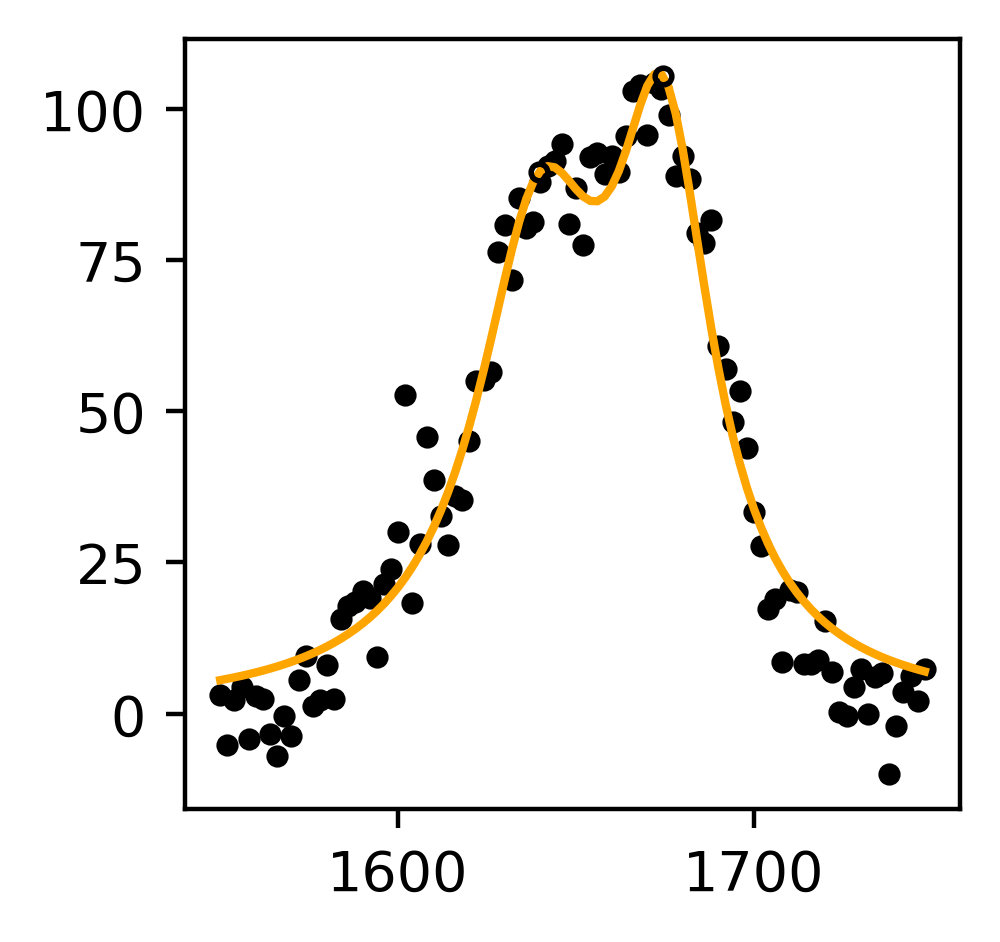

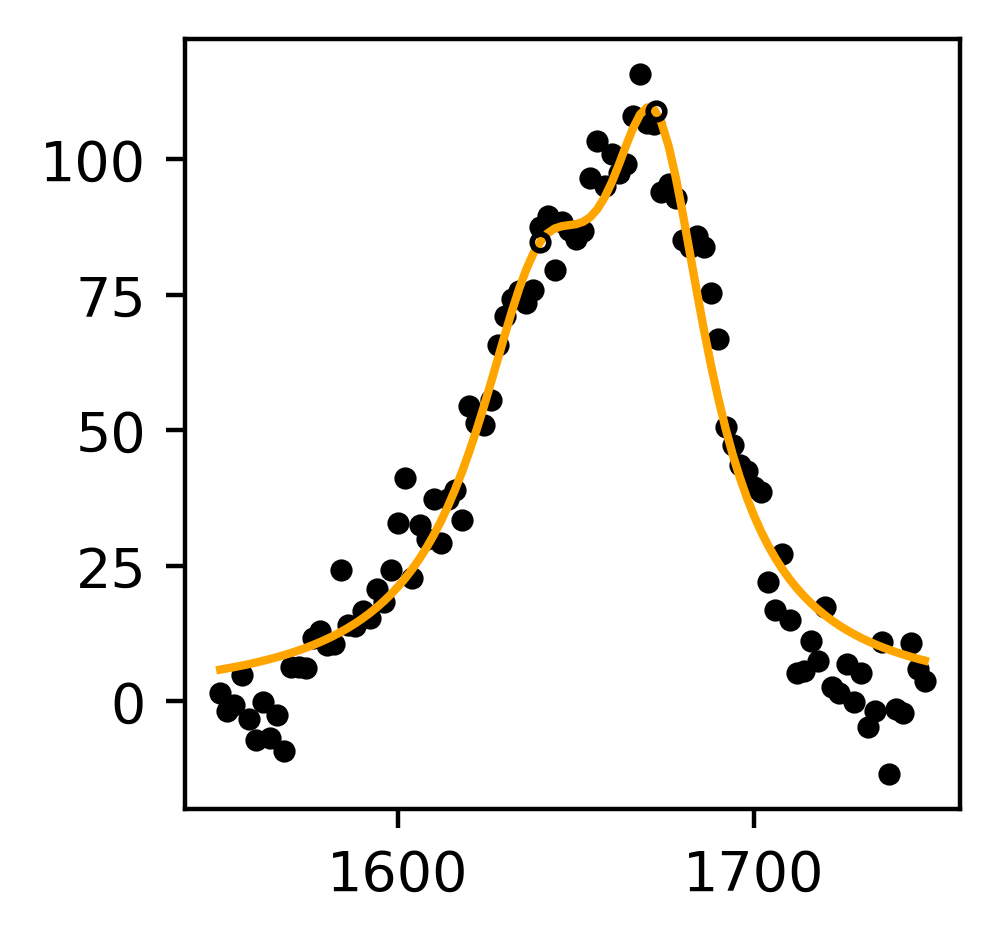

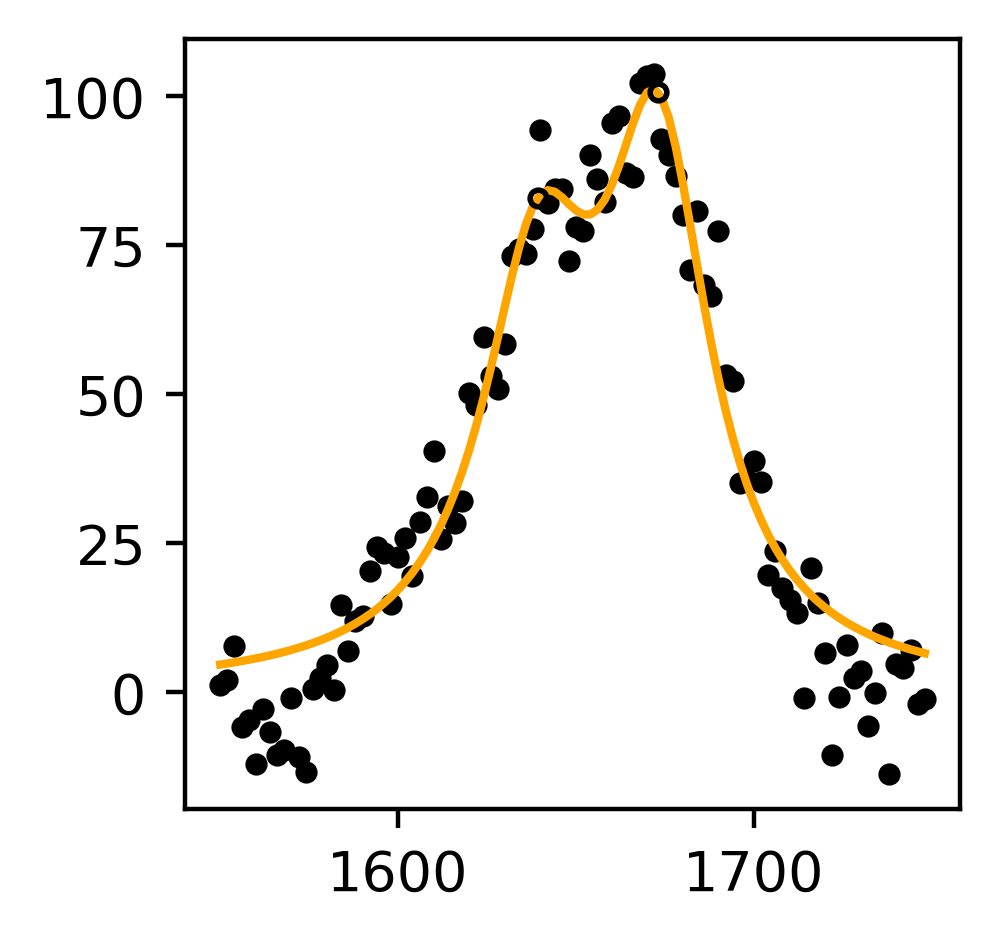

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


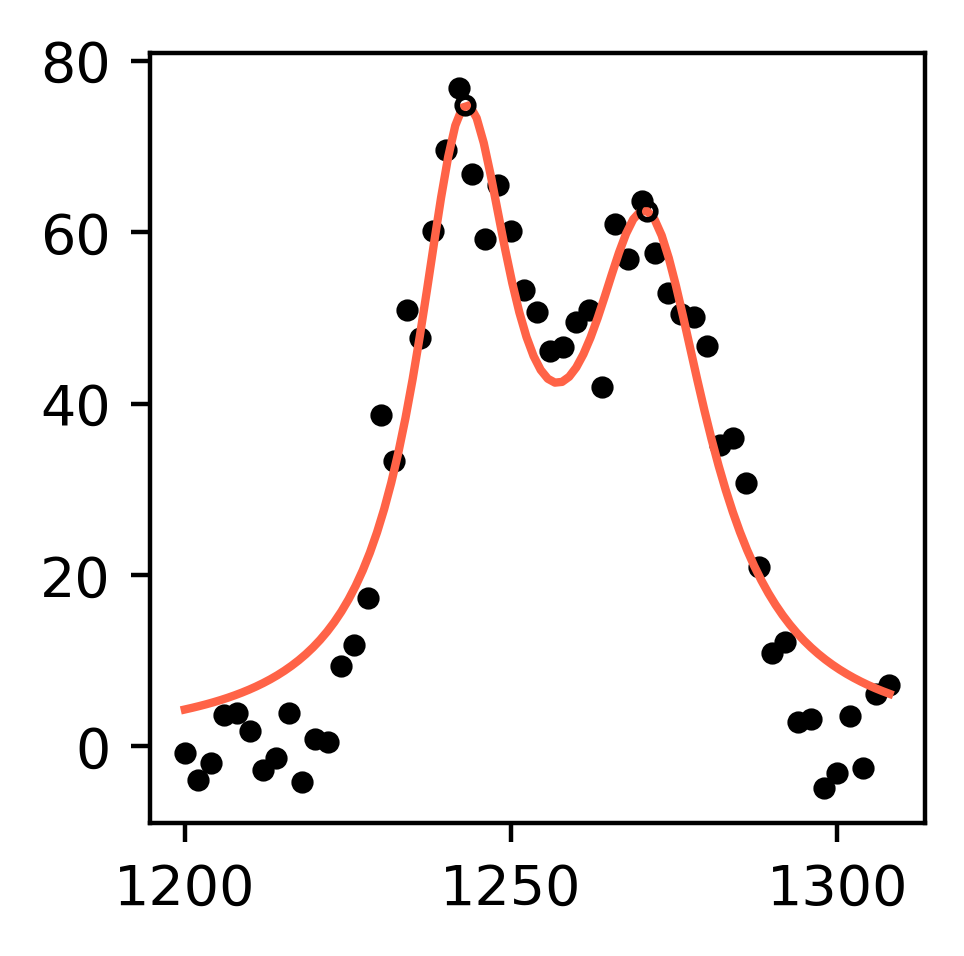

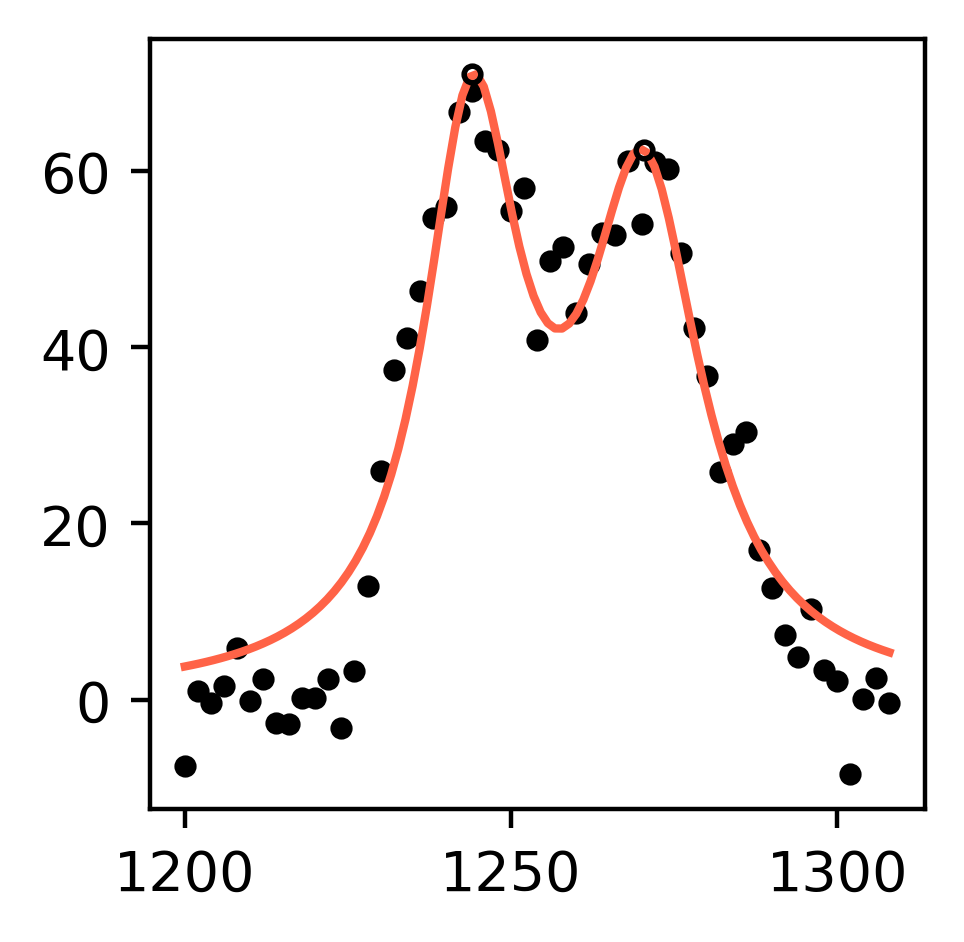

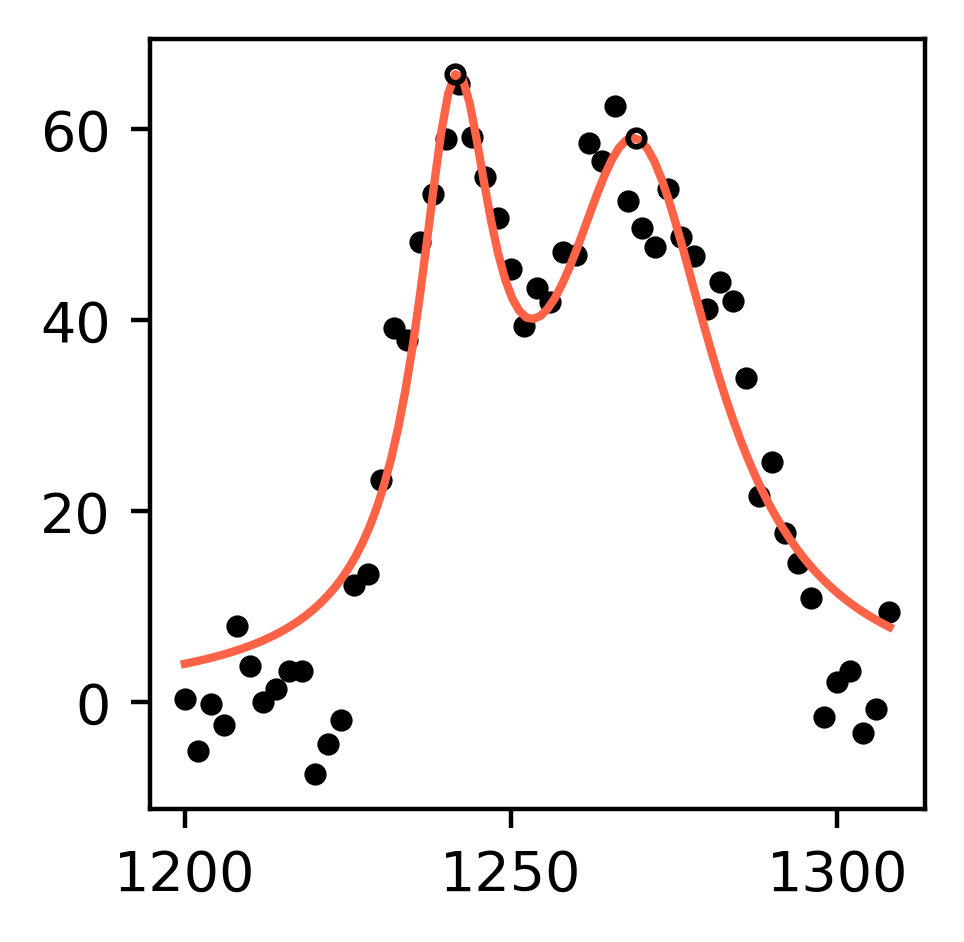

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


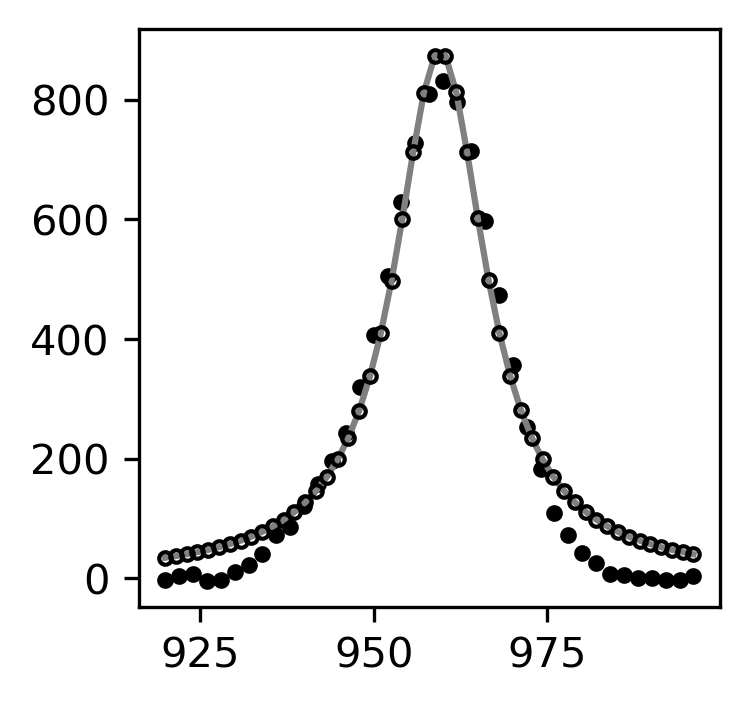

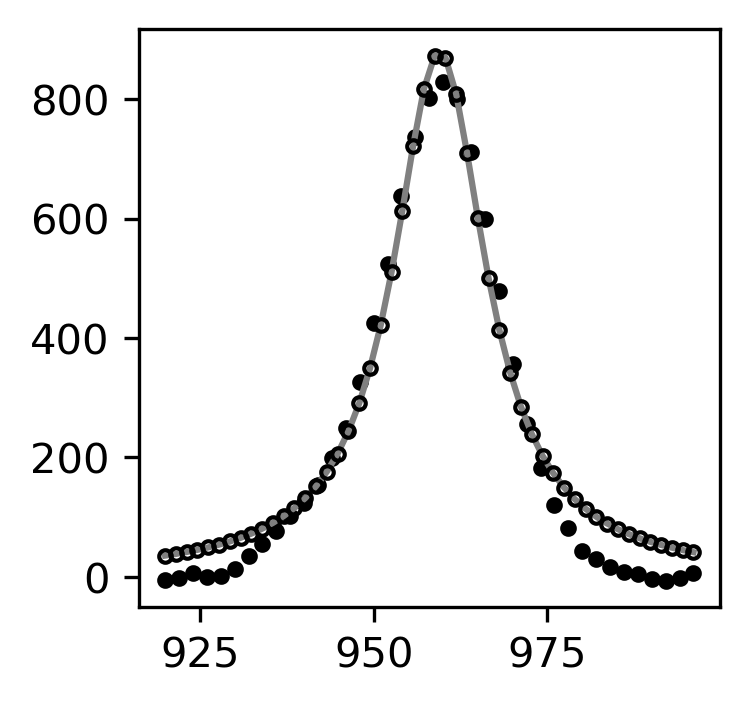

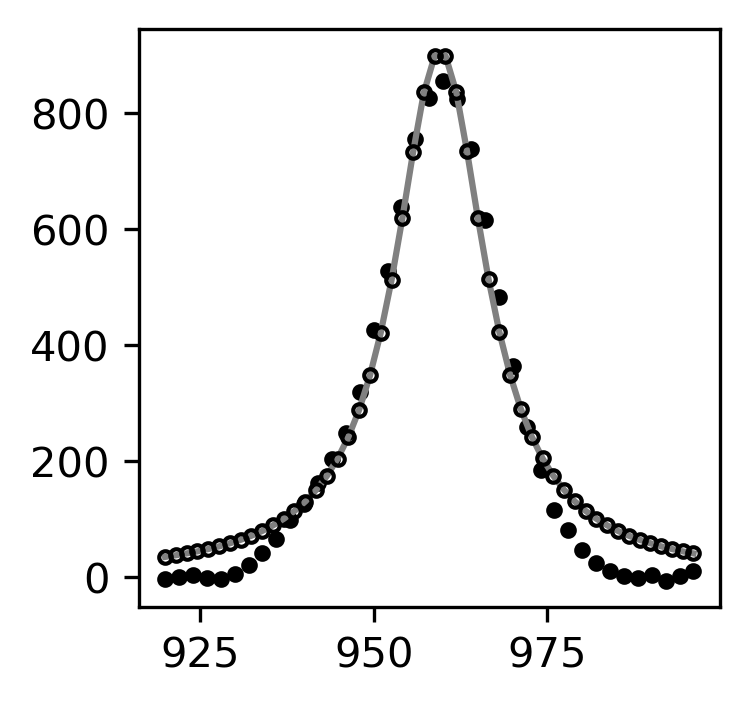

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


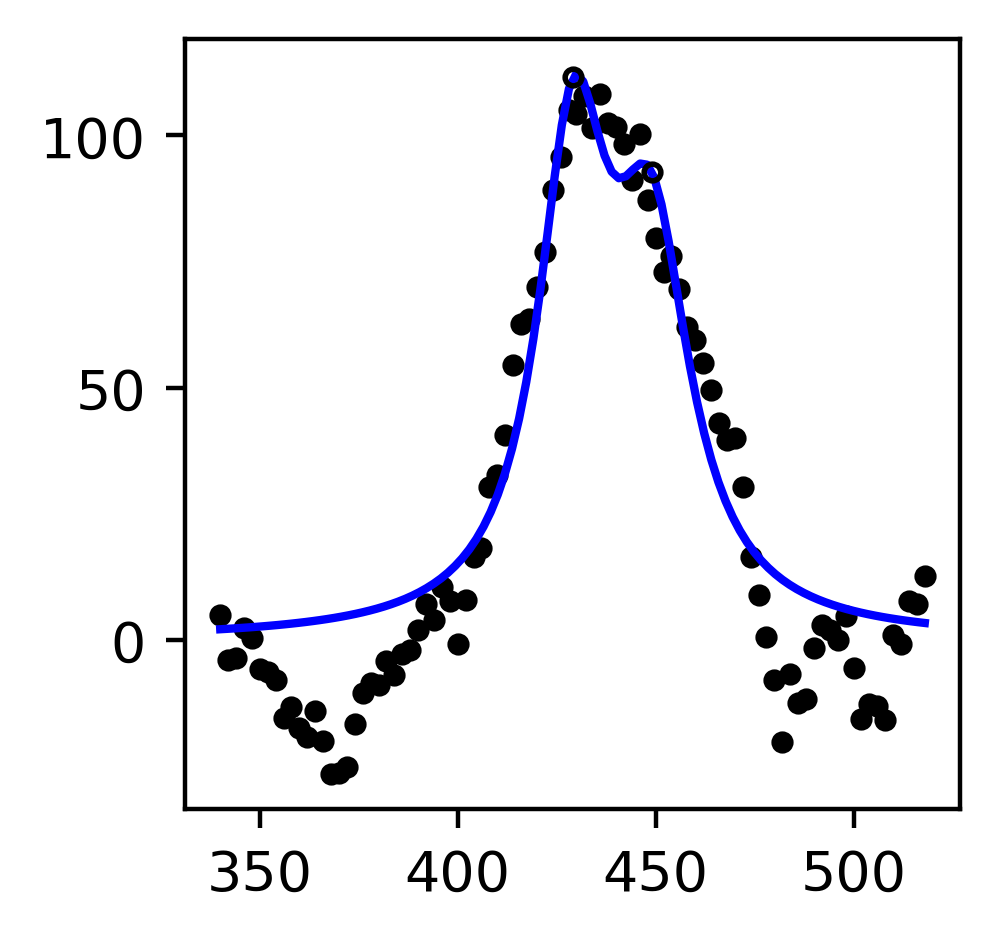

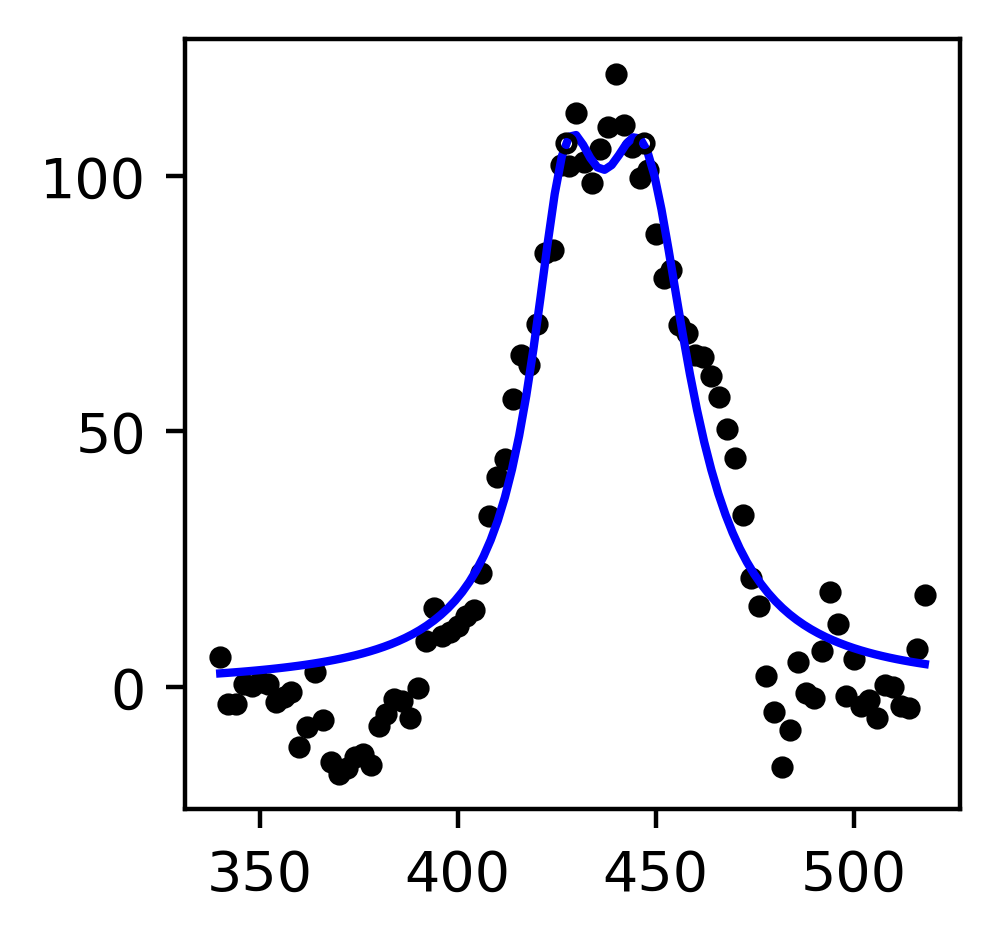

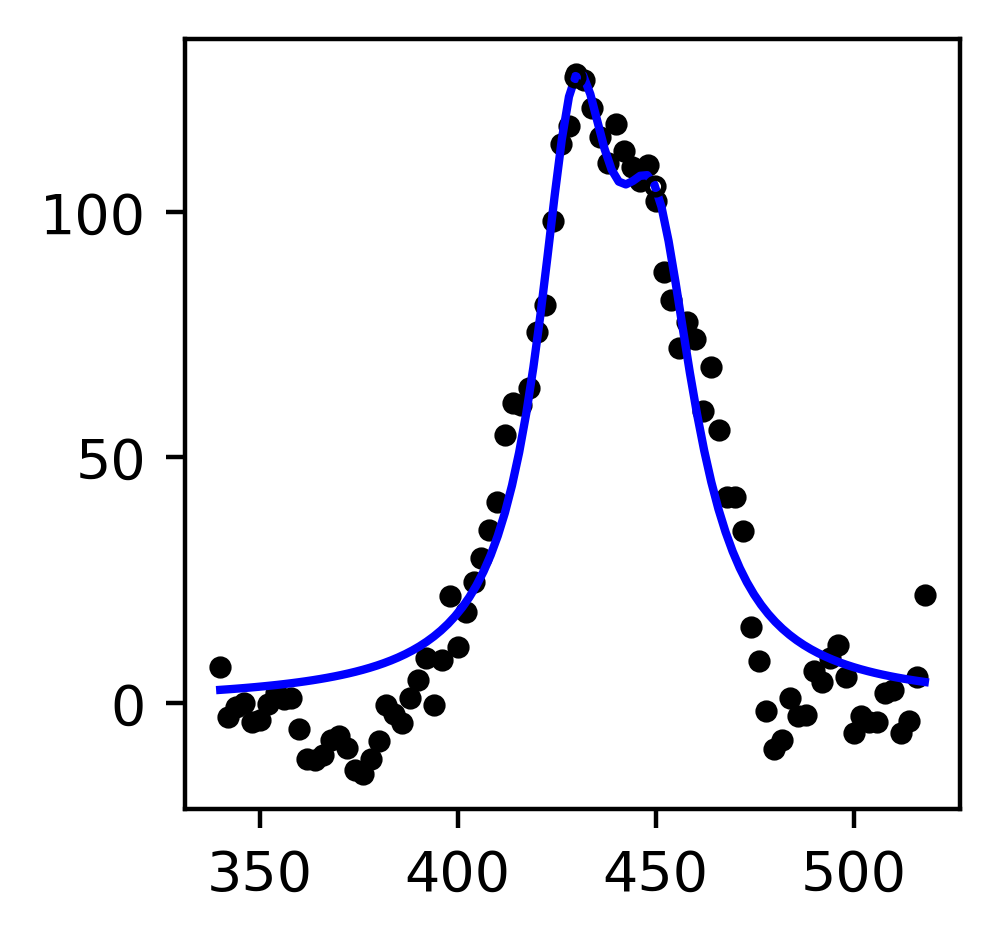

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


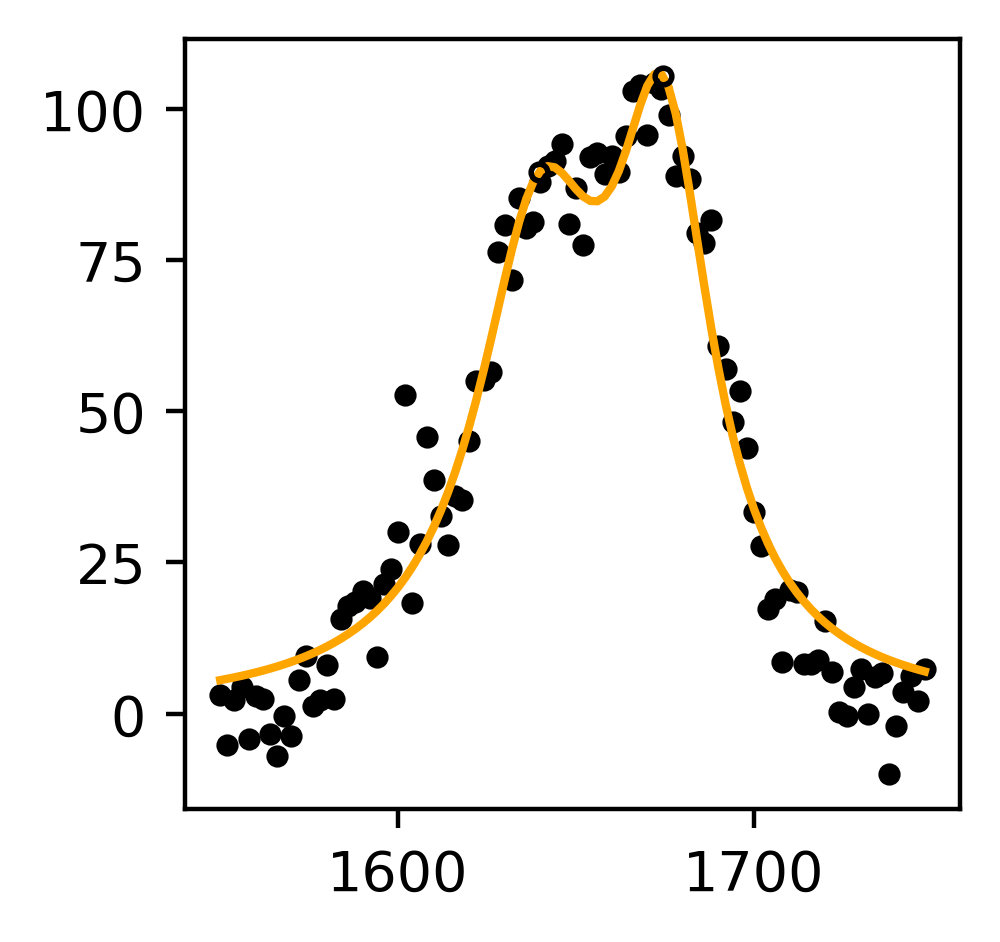

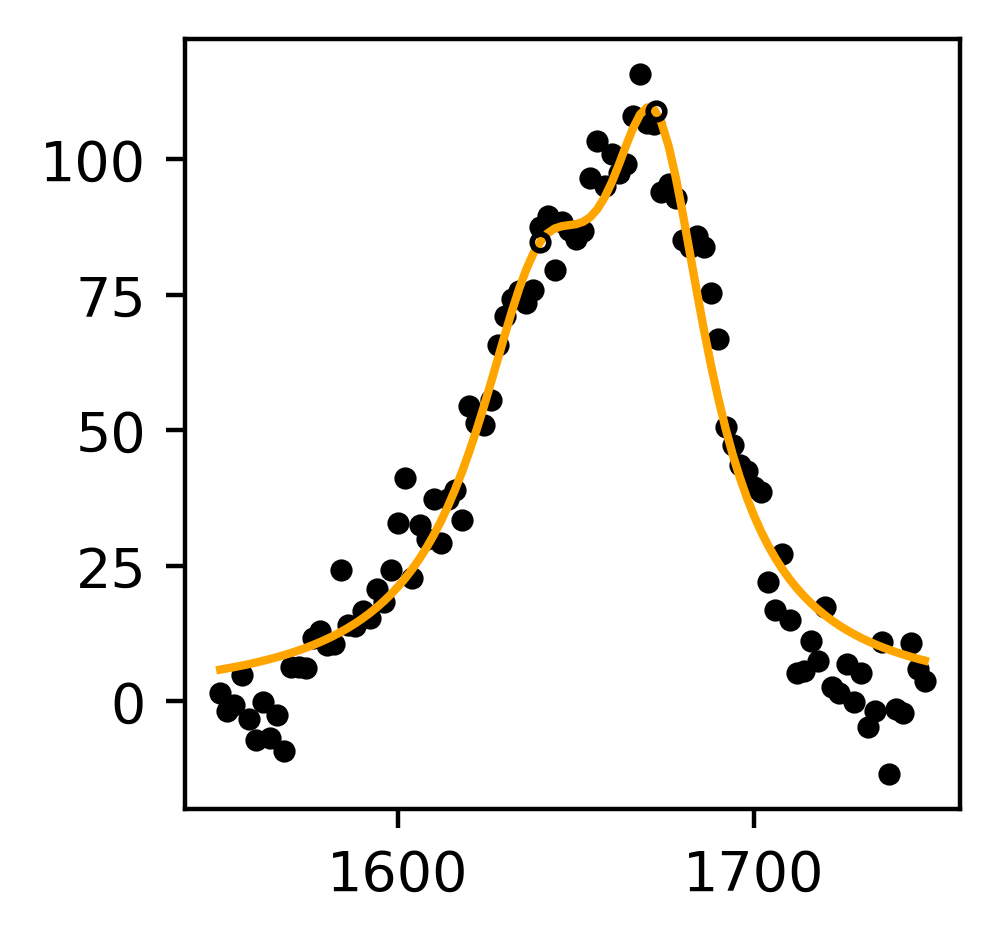

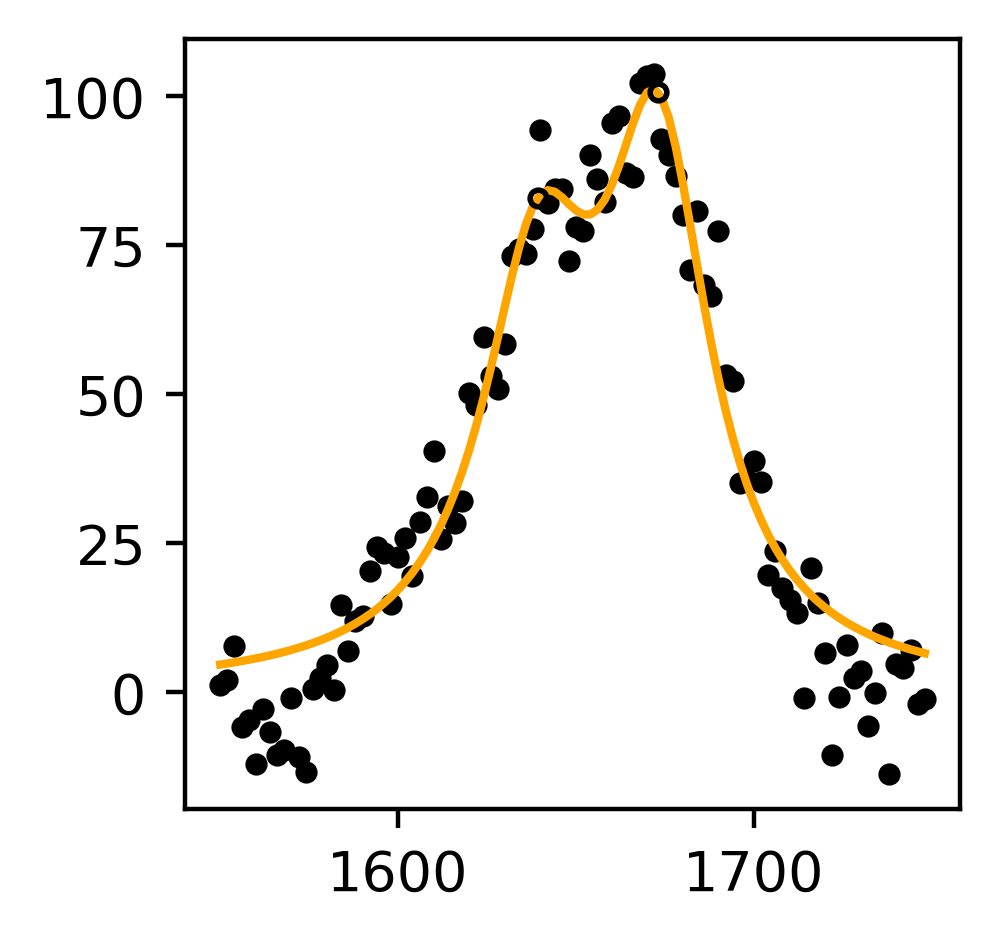

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


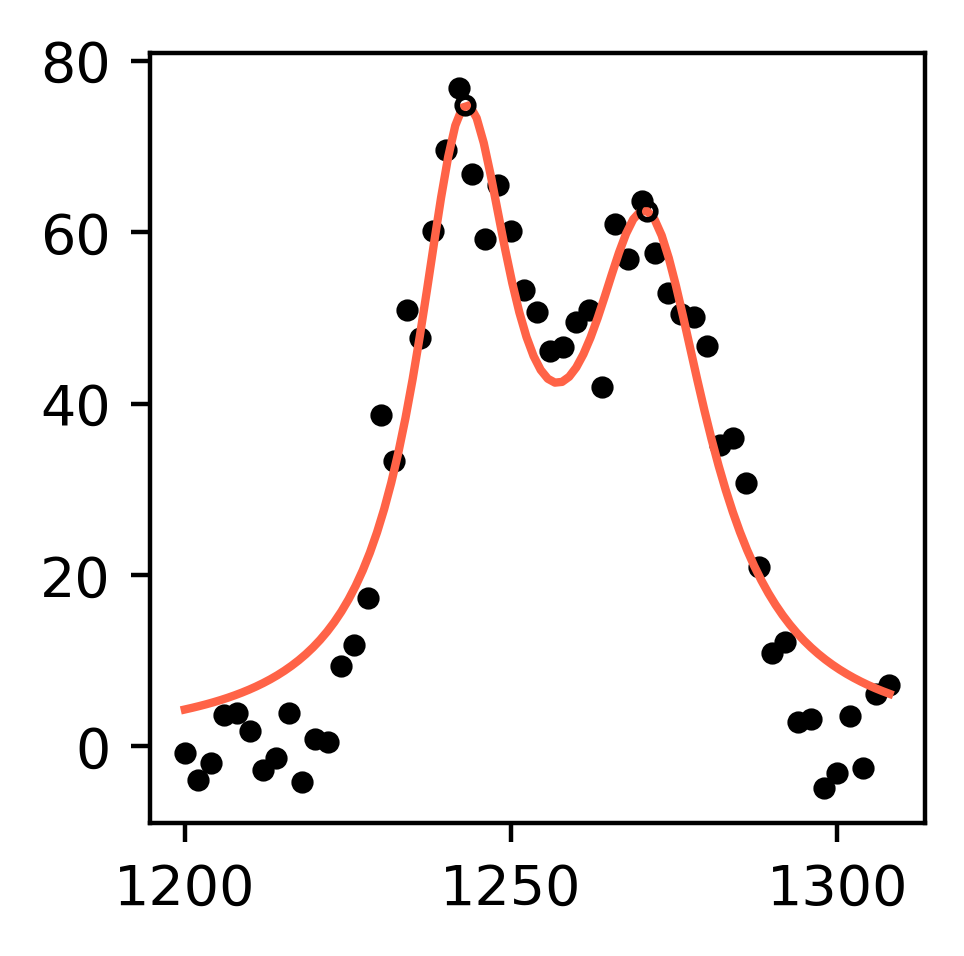

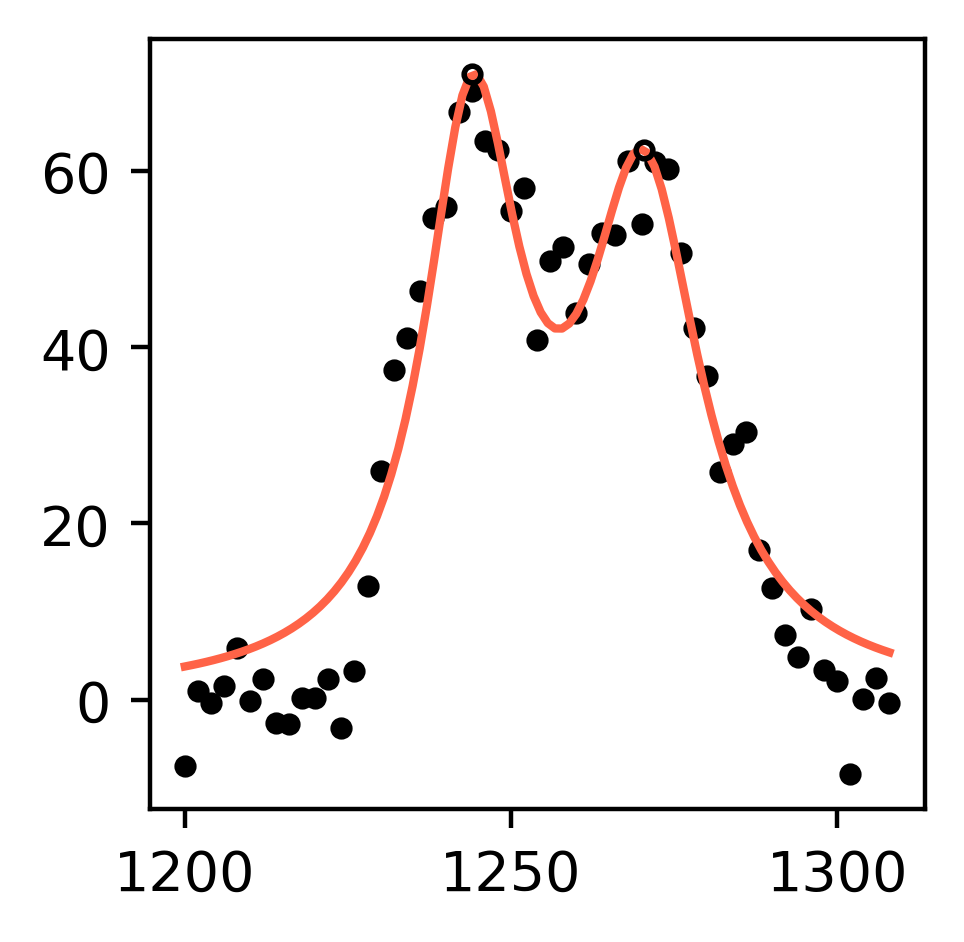

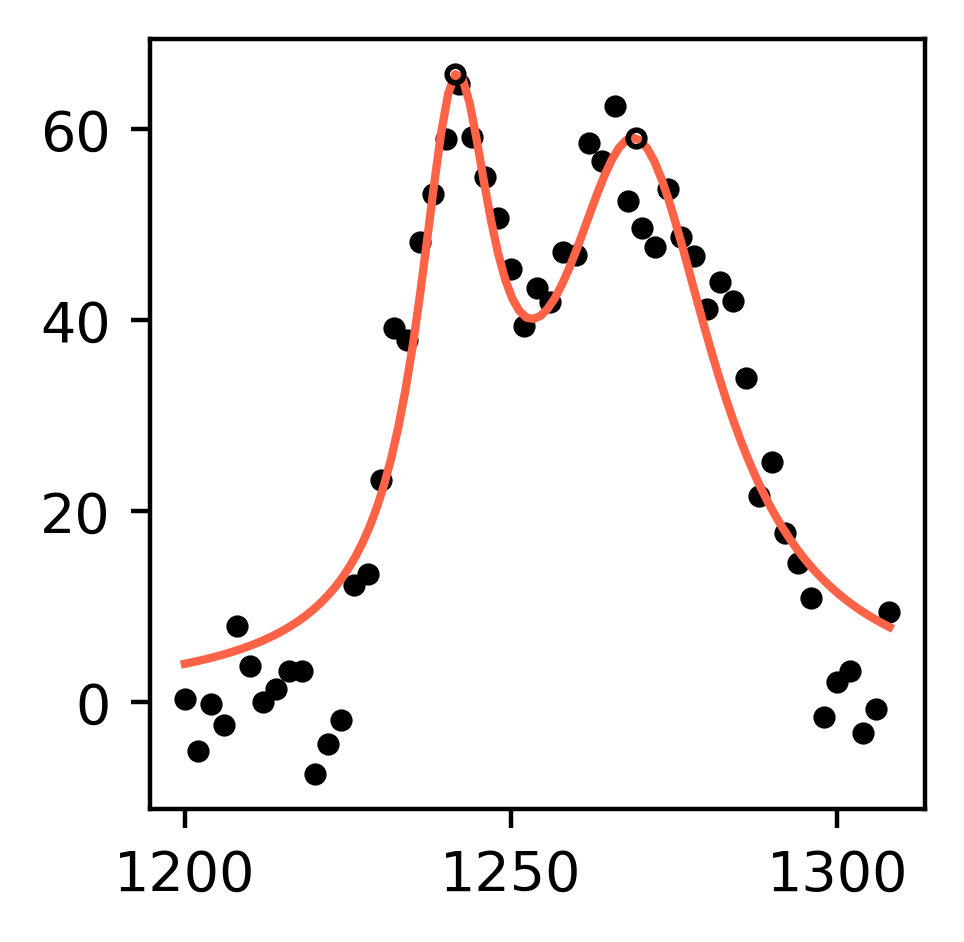

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


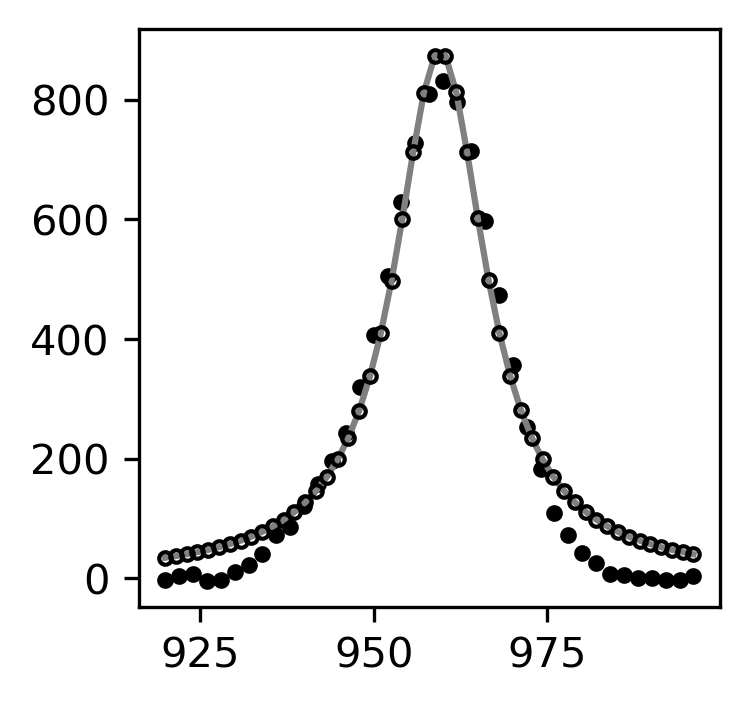

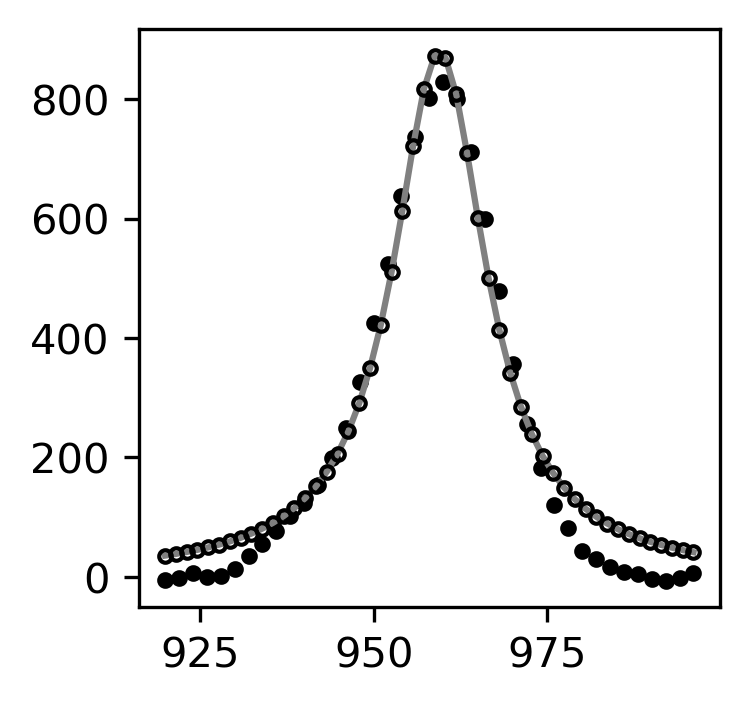

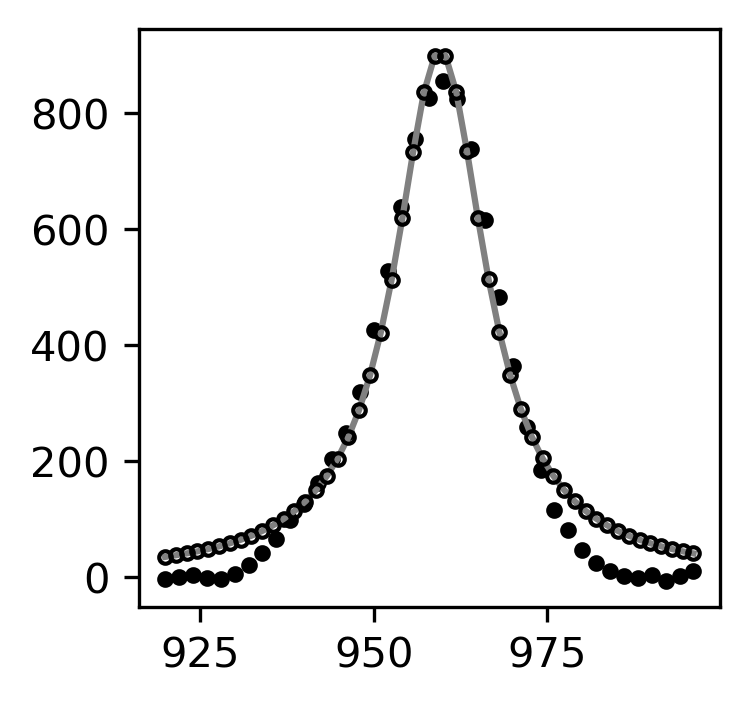

C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p = p.append(pd.DataFrame(np.polyfit(x_sides, y_sides, 1)).T, ignore_index=True)
C:\Users\koche\AppData\Local\Temp\ipykernel_21688\2200845964.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BGcounts = BGcounts.append(pd.DataFrame(np.polyval(p.values[row,:], peak_shifts.values)), ignore_index=True)


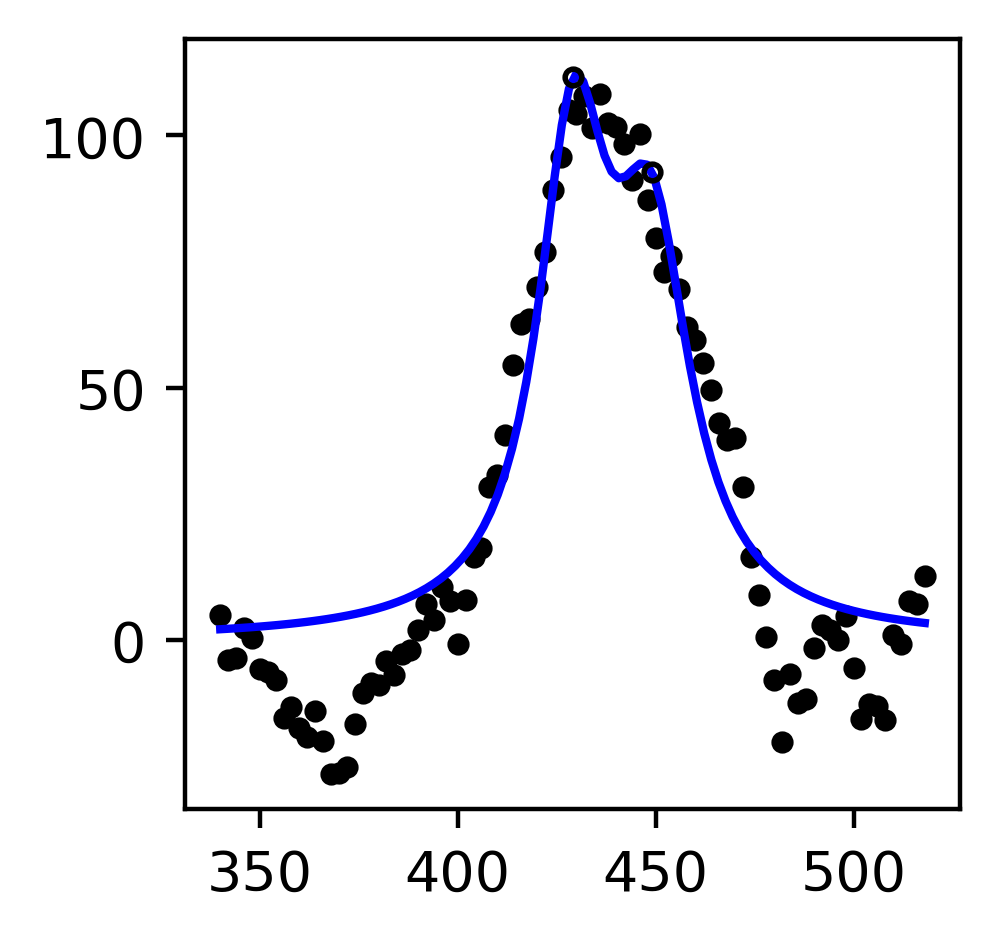

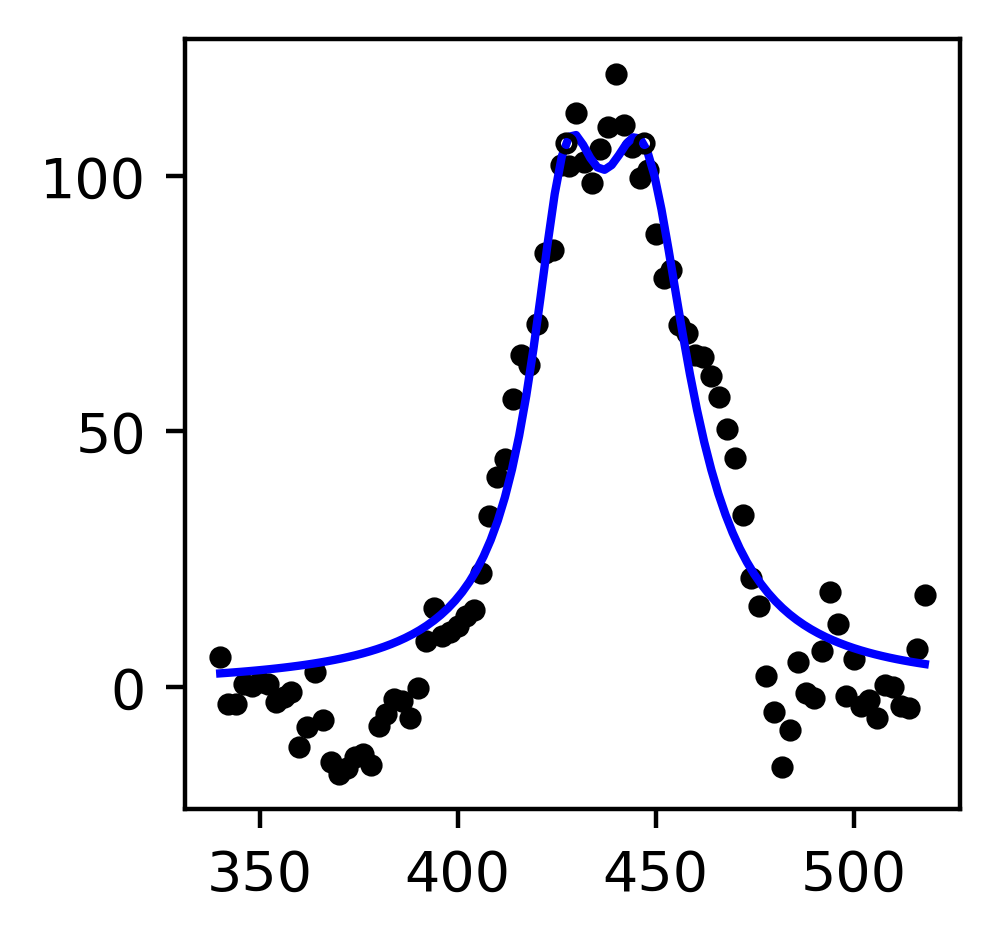

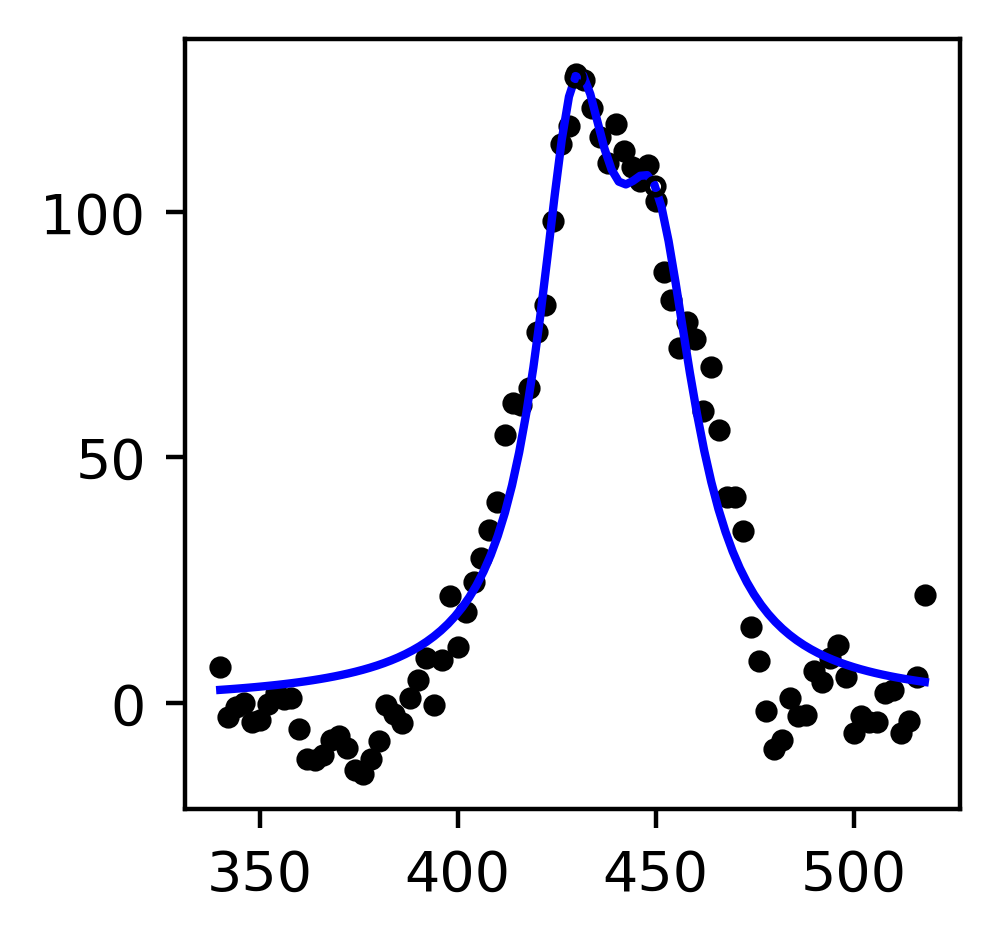

In [102]:
sample_name = ['1', '2'] 
all_output_data = pd.DataFrame()
all_spectraBG_mean = pd.DataFrame()
all_spectraBG_SD = pd.DataFrame()
for n in sample_name: 
    src_directory = data_directory+'/'+ n
    all_data, nameit = combine_files(src_directory)
    corrcounts = subtract_BG(all_data,fitorder=2)  # BG subtraction from ALL data
    plot_dataframe(all_data,src_directory,nameit, 'RawData.png') # BG subtracted data plot
    plot_dataframe(corrcounts,src_directory,nameit,'BGdata.png',cut = True) # BG subtracted data plot
    
    amideI_param = amideI_analysis(corrcounts, src_directory)
    amideIII_param = amideIII_analysis(corrcounts, src_directory)
    v1PO4_param = v1PO4_analysis(corrcounts, src_directory)
    v2PO4_param = v2PO4_analysis(corrcounts, src_directory)
    output_data = pd.concat([amideI_param, amideIII_param], axis=1)
    output_data = pd.concat([output_data, v1PO4_param], axis=1)
    output_data = pd.concat([output_data, v2PO4_param], axis=1)
    output_data['col_dis/order_aIII'] = output_data['amideIII_intensity_left']/output_data['amideIII_intensity_right']
    # output_data['col_dis/order_aI'] = output_data['amideI_intensity_2']/output_data['amideI_intensity_1']
    output_data['crosslink_enzymatic'] = output_data['amideI_intensity_left']/output_data['amideI_intensity_right']
    output_data['crystallinity'] = abs(1 / output_data['v1PO4_FWHM'])
    output_data['M2M_ratio_v2/a3'] = output_data['v2PO4_integral']/output_data['amideIII_integral']
    # output_data_mean = pd.DataFrame(output_data.mean(axis=0)).T
    # output_data_sd = pd.DataFrame(output_data.std(axis=0)).T
    output_data.insert(0, "Sample", n, True)
    all_output_data = pd.concat([all_output_data, output_data], ignore_index=True)

In [65]:
all_spectraBG_mean

,210.0,212.0,214.0,216.0,218.0,220.0,222.0,224.0,226.0,228.0,...,2062.0,2064.0,2066.0,2068.0,2070.0,2072.0,2074.0,2076.0,2078.0,2080.0
0,-36.808082,-37.733524,-39.444951,-37.659028,-40.802423,-42.165136,-42.3005,-47.425181,-48.63918,-49.829163,...,5.349051,6.918805,17.815908,9.927027,16.038828,14.757978,19.814477,18.218325,9.726189,22.321402
1,-36.808082,-37.733524,-39.444951,-37.659028,-40.802423,-42.165136,-42.3005,-47.425181,-48.63918,-49.829163,...,5.349051,6.918805,17.815908,9.927027,16.038828,14.757978,19.814477,18.218325,9.726189,22.321402


In [ ]:
# Plot averaged spectra with shaded standard deviation regions  
plotSpectra_meanSD(df_mean = all_spectraBG_mean,
                   df_sd = all_spectraBG_SD,
                   # color = ['royalblue','tomato'],
                   # color = ['royalblue','tomato', 'maroon'],
                   # color = ['royalblue','grey'],
                    color = ['royalblue','gold'],
                   plot_file = os.path.join(data_directory, n+'_spectra_meanSD.png'))
    
# BOXPLOTS
boxplot(df = all_output_data[all_output_data['Sample']==n],
             column = 'col_dis/order_aIII',
             plot_title = 'Relative collagen disorganization',
             x_label = 'Sample '+n,
             y_label = 'I~1245/I~1267',
             plot_file = os.path.join(data_directory, n+'_Col_DisOrder_amideIII.png'))

# boxplot_heat(df = all_output_data[all_output_data['Sample']==n],
#              column = 'col_dis/order_aI',
#              plot_title = 'Relative collagen disorganization',
#              x_label = 'Sample '+name,
#              y_label = 'I~1670/I~1640',
#              plot_file = os.path.join(start_dir, n+'_Col_DisOrder_amideI.png'))

boxplot(df = all_output_data[all_output_data['Sample']==n],
             column = 'crosslink_enzymatic',
             plot_title = 'Matrix maturity ratio',
             x_label = 'Sample '+n,
             y_label = 'I~1670/I~1690',
             plot_file = os.path.join(data_directory, n+'_Matrix_maturity.png'))

boxplot(df = all_output_data[all_output_data['Sample']==n],
             column = 'crystallinity',
             plot_title = 'Crystallinity',
             x_label = 'Sample '+n,
             y_label = 'v1PO4 FWHM-1',
             plot_file = os.path.join(data_directory, n+'_crystallinity.png'))

boxplot(df = all_output_data[all_output_data['Sample']==n],
             column = 'M2M_ratio_v2/a3',
             plot_title = 'Relative mineralization',
             x_label = 'Sample '+n,
             y_label = 'Mineral/Matrix (v2PO4/amide III)',
             plot_file = os.path.join(data_directory, n+'_MMRv2a3.png'))